# Evaluation Test Data

In [1]:
from picturedata.generator import DataGenerator
from keras.models import load_model
from keras.preprocessing import image, sequence
import numpy as np
import pandas as pd
from keras import backend as K
from keras.applications.vgg16 import VGG16
import nltk
from imagenet_utils import preprocess_input

Using TensorFlow backend.


In [2]:
generator = DataGenerator()

Total samples : 383454
Vocabulary size: 8256
Maximum caption length: 40
Image count: 30000


Processing images from test dataset on VGG-16

In [3]:
f_images = open('Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt', 'rb')
imgs = f_images.read().strip().split('\n')
f_images.close()

In [4]:
vgg_model = VGG16(weights='imagenet', include_top=True, input_shape = (224, 224, 3))
img_dir = "Flickr8k/Flicker8k_Dataset/"
c = 0
img_features = {}
for img in imgs:
    c += 1
    img_s = image.load_img(img_dir + img, target_size=(224, 224))
    img_s = image.img_to_array(img_s)
    img_s = np.expand_dims(img_s, axis=0)
    img_s = preprocess_input(img_s)
    img_s = np.asarray(img_s)
    img_feature = vgg_model.predict(img_s)
    #img_feature = np.asarray(img_feature)
    #img_feature = img_feature.argmax(axis=-1)
    if c % 100 == 0:
        print "Processed {0} images".format(c)
    img_features[img] = img_feature[0]
K.clear_session()

Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 800 images
Processed 900 images
Processed 1000 images


Load model and best weights

In [5]:
model = load_model('Models/WholeModel.h5')

/home/ubuntu/.local/lib/python2.7/site-packages/keras/engine/topology.py:1242: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


In [45]:
model.load_weights('weights-improvement-00.hdf5')

Generating caption for a single image

In [75]:
img = '2521770311_3086ca90de.jpg'
image_feature = img_features[img]
start = [generator.word_index['<start>']]
captions = [[start, 0.0]]
while(len(captions[0][0]) < generator.max_cap_len):
    temp_captions = []
    for caption in captions:
        partial_caption = sequence.pad_sequences([caption[0]], maxlen=generator.max_cap_len, padding='post')
        next_words_pred = model.predict([np.asarray([image_feature]), np.asarray(partial_caption)])[0]
        next_words = np.argsort(next_words_pred)[-3:]
        for word in next_words:
            new_partial_caption, new_partial_caption_prob = caption[0][:], caption[1]
            new_partial_caption.append(word)
            new_partial_caption_prob+=next_words_pred[word]
            temp_captions.append([new_partial_caption,new_partial_caption_prob])
    
    captions = temp_captions
    captions.sort(key = lambda l:l[1])
    captions = captions[-3:]

    
captions.sort(key = lambda l:l[1])
best_caption = captions[-1][0]
caption = " ".join([generator.index_word[index] for index in best_caption])

caption_split = caption.split()
processed_caption = caption_split[1:]

try:
    end_index = processed_caption.index('<end>')
    processed_caption = processed_caption[:end_index]
except:
    pass
sentence = " ".join([word for word in processed_caption])
print sentence


A little girl in a black shirt is in the background .


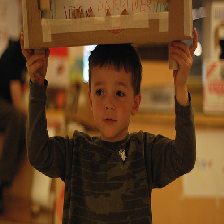

In [76]:
img = image.load_img(img_dir + img, target_size=(224, 224))
img

Save all caption generated and actual caption image pair to calculate BLEU

In [10]:
f_captions = open('Flickr8k/Flickr8k_text/Flickr8k.token.txt', 'rb')
captions_text = f_captions.read().strip().split('\n')
image_captions_pair = {}
for row in captions_text:
    row = row.split("\t")
    row[0] = row[0][:len(row[0])-2]
    try:
        image_captions_pair[row[0]].append(row[1])
    except:
        image_captions_pair[row[0]] = [row[1]]
    f_captions.close()
    
hypotheses=[]
references = []

for img in imgs:
    image_feature = img_features[img]
    start = [generator.word_index['<start>']]
    captions = [[start, 0.0]]
    while(len(captions[0][0]) < generator.max_cap_len):
        temp_captions = []
        for caption in captions:
            partial_caption = sequence.pad_sequences([caption[0]], maxlen=generator.max_cap_len, padding='post')
            next_words_pred = model.predict([np.asarray([image_feature]), np.asarray(partial_caption)])[0]
            next_words = np.argsort(next_words_pred)[-3:]
            for word in next_words:
                new_partial_caption, new_partial_caption_prob = caption[0][:], caption[1]
                new_partial_caption.append(word)
                new_partial_caption_prob+=next_words_pred[word]
                temp_captions.append([new_partial_caption,new_partial_caption_prob])
    
        captions = temp_captions
        captions.sort(key = lambda l:l[1])
        captions = captions[-3:]

    
    captions.sort(key = lambda l:l[1])
    best_caption = captions[-1][0]
    caption = " ".join([generator.index_word[index] for index in best_caption])

    caption_split = caption.split()
    processed_caption = caption_split[1:]

    try:
        end_index = processed_caption.index('<end>')
        processed_caption = processed_caption[:end_index]
    except:
        pass
    sentence = " ".join([word for word in processed_caption])
    print img + " ----- " + sentence
    

    hypothesis = sentence
    reference = image_captions_pair[img]
    hypotheses.append(hypothesis)
    references.append(reference)

3385593926_d3e9c21170.jpg ----- A black and white dog in a field .
2677656448_6b7e7702af.jpg ----- A black and white dog in a field .
311146855_0b65fdb169.jpg ----- A little girl in a black shirt and a girl in the background .
1258913059_07c613f7ff.jpg ----- A little girl in a toy in a toy .
241347760_d44c8d3a01.jpg ----- A man in a black shirt is in a field .
2654514044_a70a6e2c21.jpg ----- A black and white dog is in the grass .
2339106348_2df90aa6a9.jpg ----- A little girl in a black shirt and a girl in a toy .
256085101_2c2617c5d0.jpg ----- A black and white dog is in the grass .
280706862_14c30d734a.jpg ----- A black dog is in the grass .
3072172967_630e9c69d0.jpg ----- A man in a black shirt is in a field .
3482062809_3b694322c4.jpg ----- A little girl in a toy in a toy .
1167669558_87a8a467d6.jpg ----- A little girl in a black shirt is in the background .
2847615962_c330bded6e.jpg ----- A black and white dog in a field .
3344233740_c010378da7.jpg ----- A little girl in a toy in 

3484832904_08619300d9.jpg ----- A man in a black shirt is in a field .
3365783912_e12c3510d8.jpg ----- A man in a black shirt is in the air .
3185409663_95f6b958d8.jpg ----- A black and white dog in a field .
3207358897_bfa61fa3c6.jpg ----- A man in a black shirt is in the air .
3263497678_8bb688ca01.jpg ----- A little girl in a black shirt is in a field .
1897025969_0c41688fa6.jpg ----- A black and white dog in a field .
3657016761_d553e514d9.jpg ----- A little girl in a black shirt is in the background .
3537400880_8f410d747d.jpg ----- A little girl in a black shirt is in the air .
2419221084_01a14176b4.jpg ----- A black and white dog is in the grass .
172097782_f0844ec317.jpg ----- A man in a black shirt is in the background .
244571201_0339d8e8d1.jpg ----- A black and white dog in a field .
3467219837_7d62213dec.jpg ----- A man in a black shirt is in a field .
2928152792_b16c73434a.jpg ----- A man in a black shirt is in the air .
401079494_562454c4d6.jpg ----- A black and white dog

488590040_35a3e96c89.jpg ----- A little girl in a black shirt is in the background .
3217266166_4e0091860b.jpg ----- A man in a black shirt is in the air .
3246991821_750a3097e2.jpg ----- A little girl in a black shirt is in the background .
3048597471_5697538daf.jpg ----- A black and white dog is in the grass .
2854959952_3991a385ab.jpg ----- A black and white dog is in the grass .
2084217208_7bd9bc85e5.jpg ----- A man in a black shirt is in the air .
435827376_4384c3005a.jpg ----- A man in a black shirt is in the air .
2944362789_aebbc22db4.jpg ----- A man in a black shirt is in the air .
2497420371_74788d7ba1.jpg ----- A man in a black shirt is in the air .
309687244_4bdf3b591f.jpg ----- A man in a black shirt is in the air .
3433982387_3fa993cf5a.jpg ----- A little girl in a black shirt and a white shirt and a black shirt and a girl in a field .
2782433864_5a0c311d87.jpg ----- A black and white dog in a field .
136552115_6dc3e7231c.jpg ----- A man in a black shirt is in the air .
1

2704934519_457dc38986.jpg ----- A man in a black shirt is in the air .
3499720588_c32590108e.jpg ----- A little girl in a black shirt is in the background .
506738508_327efdf9c3.jpg ----- A little girl in a black shirt and a girl in a toy .
512101751_05a6d93e19.jpg ----- A black and white dog is in the grass .
2317714088_bcd081f926.jpg ----- A man in a black shirt is in the air .
3275704430_a75828048f.jpg ----- A little girl in a black shirt and a white shirt and a girl in a toy .
2518508760_68d8df7365.jpg ----- A man in a black shirt is in a field .
3254817653_632e840423.jpg ----- A little girl in a black shirt and a white shirt and a girl in a toy .
3113322995_13781860f2.jpg ----- A black and white dog in a field .
2103568100_5d018c495b.jpg ----- A black and white dog in a field .
3518126579_e70e0cbb2b.jpg ----- A man in a black shirt is in the air .
2192131110_8a40e7c028.jpg ----- A man in a black shirt is in the air .
2581066814_179d28f306.jpg ----- A man in a black shirt is in the

352382023_7605223d1c.jpg ----- A black and white dog is in the grass .
247704641_d883902277.jpg ----- A black and white dog in a field .
3461041826_0e24cdf597.jpg ----- A black and white dog is in the grass .
3358558292_6ab14193ed.jpg ----- A little girl in a black shirt and a girl in a toy .
525863257_053333e612.jpg ----- A black and white dog is in the grass .
2112921744_92bf706805.jpg ----- A man in a black shirt is in the air .
375392855_54d46ed5c8.jpg ----- A man in a black shirt is in the air .
1917265421_aeccf1ca38.jpg ----- A man in a black shirt is in the air .
1659358141_0433c9bf99.jpg ----- A black and white dog in a field .
2533642917_a5eace85e6.jpg ----- A man in a black shirt is in the air .
2204550058_2707d92338.jpg ----- A little girl in a blue shirt and a black shirt and a black shirt and a girl in a field .
2764178773_d63b502812.jpg ----- A man in a black shirt is in a field .
180094434_b0f244832d.jpg ----- A man in a black shirt is in the air .
2308978137_bfe776d541.

2384353160_f395e9a54b.jpg ----- A little girl in a black shirt and a girl in a field .
3245912109_fdeef6b456.jpg ----- A man in a black shirt is in the air .
3613955682_3860e116cf.jpg ----- A man in a black shirt is in a field .
2866254827_9a8f592017.jpg ----- A man in a black shirt is in the air .
160792599_6a7ec52516.jpg ----- A man in a black shirt is in the grass .
3108732084_565b423162.jpg ----- A man in a black shirt is in the air .
2991994607_06f24ec7a6.jpg ----- A little girl in a black shirt and a white shirt and a girl in a field .
542179694_e170e9e465.jpg ----- A man in a black shirt is in the air .
136644343_0e2b423829.jpg ----- A little girl in a toy in the background .
3605061440_1d08c80a57.jpg ----- A little girl in a black shirt is in the background .
2358554995_54ed3baa83.jpg ----- A little girl in a black shirt is in the background .
3138399980_d6ab8b2272.jpg ----- A man in a black shirt is in the air .
2944836001_b38b516286.jpg ----- A little girl in a black shirt is

1461667284_041c8a2475.jpg ----- A little girl in a black shirt and a white shirt and a girl in a field .
2196316998_3b2d63f01f.jpg ----- A little girl in a black shirt is in the background .
1998457059_c9ac9a1e1a.jpg ----- A man in a black shirt is in the air .
3294209955_a1f1e2cc19.jpg ----- A black and white dog is in the grass .
488408004_a1e26d4886.jpg ----- A little girl in a black shirt is in a toy .
3135504530_0f4130d8f8.jpg ----- A little girl in a black shirt and a white shirt and a girl in a field .
3217910740_d1d61c08ab.jpg ----- A little girl in a toy in a toy .
3602838407_bf13e49243.jpg ----- A black and white dog is in the grass .
2984174290_a915748d77.jpg ----- A man in a black shirt is in the air .
424779662_568f9606d0.jpg ----- A little girl in a black shirt and a girl in a toy .
2431832075_00aa1a4457.jpg ----- A man in a black shirt is in the air .
624742559_ff467d8ebc.jpg ----- A little girl in a toy in a field .
3157847991_463e006a28.jpg ----- A man in a black shirt

3413571342_b9855795e2.jpg ----- A little girl in a toy in the background .
2475162978_2c51048dca.jpg ----- A little girl in a black shirt is in a field .
2160266952_a2ab39191b.jpg ----- A little girl in a black shirt is in the background .
463978865_c87c6ca84c.jpg ----- A man in a black shirt is in the air .
3585487286_ef9a8d4c56.jpg ----- A black and white dog in a field .
3239021459_a6b71bb400.jpg ----- A man in a black shirt is in the air .
2662845514_8620aaee96.jpg ----- A little girl in a black shirt is in the background .
3044746136_8b89da5f40.jpg ----- A little girl in a black shirt and a girl in a toy .
343218198_1ca90e0734.jpg ----- A black and white dog is running in the grass .
2924259848_effb4dcb82.jpg ----- A man in a black shirt is in the air .
3720366614_dfa8fe1088.jpg ----- A black and white dog in a field .
1356796100_b265479721.jpg ----- A man in a black shirt is in the grass .
2905942129_2b4bf59bc0.jpg ----- A little girl in a toy in the background .
2660008870_b672a

1674612291_7154c5ab61.jpg ----- A black and white dog in a field .
136886677_6026c622eb.jpg ----- A man in a black shirt is in the background .
3398746625_5199beea71.jpg ----- A man in a black shirt is in a field .
3220650628_4ed964e5b4.jpg ----- A man in a black shirt is in the air .
1082379191_ec1e53f996.jpg ----- A little girl in a toy in the background .
3741462565_cc35966b7a.jpg ----- A little girl in a black shirt is in the background .
1174525839_7c1e6cfa86.jpg ----- A black and white dog in a field .
3572267708_9d8a81d4a4.jpg ----- A little girl in a blue shirt and a black shirt is in a field .
1509786421_f03158adfc.jpg ----- A little girl in a black shirt and a black shirt and a girl in the background .
3155987659_b9ea318dd3.jpg ----- A man in a black shirt is in a field .
925491651_57df3a5b36.jpg ----- A black and white dog in a field .
2735558076_0d7bbc18fc.jpg ----- A little girl in a toy in a toy .
300922408_05a4f9938c.jpg ----- A man in a black shirt is in the air .
14906

2343525685_3eba3b6686.jpg ----- A little girl in a black shirt is in the background .
416106657_cab2a107a5.jpg ----- A black and white dog in a field .
387830531_e89c192b92.jpg ----- A black and white dog in a field .
2892995070_39f3c9a56e.jpg ----- A black and white dog in a field .
3432550415_e7b77232de.jpg ----- A little girl in a toy in a field .
3564312955_716e86c48b.jpg ----- A little girl in a toy in the background .
3238951136_2a99f1a1a8.jpg ----- A man in a black shirt is in the air .
3595643050_d312e4b652.jpg ----- A black and white dog in a field .
3139876823_859c7d7c23.jpg ----- A man in a black shirt is in the air .
3473264983_67917a931f.jpg ----- A little girl in a toy in a toy .
2994179598_a45c2732b5.jpg ----- A man in a black shirt is in a field .
491405109_798222cfd0.jpg ----- A little girl in a toy in the background .
3115174046_9e96b9ce47.jpg ----- A man in a black shirt is in a field .
3631986552_944ea208fc.jpg ----- A man in a black shirt is in the air .
3350786891

Calculate BLEU

In [11]:
print nltk.translate.bleu_score.corpus_bleu(references, hypotheses)

0.50834642154


Try to retrain model to check how the loss increase on best weights loaded

In [15]:
model.fit_generator(generator.generate(batch_size=32), steps_per_epoch=generator.total_samples/32, epochs=20, verbose=1)
try:
    model.save('Models/WholeModel.h5', overwrite=True)
    model.save_weights('Models/Weights.h5',overwrite=True)
except:
    print "Error in saving model."

Epoch 1/20Generating data...

   79/11982 [..............................] - ETA: 2371s - loss: 3.5511 - acc: 0.3799

KeyboardInterrupt: 